In [1]:
!rm -rf torch_compile_debug

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
def fn(x,y):
    # x*exp(−(x^2+y^2))+(x^2+y^2)/20
    return x*torch.exp(-x**2-y**2) + (x**2+y**2)/20 

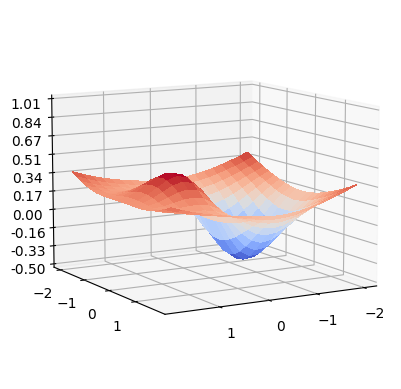

In [7]:
# Make data.
x = torch.arange(-2, 2, 0.2,requires_grad=True)
y = torch.arange(-2, 2, 0.2,requires_grad=True)
x, y = torch.meshgrid(x, y, indexing='ij')
r = fn(x,y)
z = torch.sin(r)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(x.detach().numpy(), y.detach().numpy(), z.detach().numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.5, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(10, 60)
plt.show()

In [7]:
fn_compiled = torch.compile(fn, backend="inductor", 
                       options={'trace.graph_diagram':True,
                                'trace.enabled':True})

out = fn_compiled(x.to(device), y.to(device)).sum().backward()

[2023-03-21 07:04:09,637] torch._inductor.debug: [WARNING] model__1_forward_4 debug trace: /pytorch-examples/pytorch-graph-optim/torch_compile_debug/run_2023_03_21_07_03_48_329556-pid_24339/aot_torchinductor/model__1_forward_4.2
[2023-03-21 07:04:09,677] torch._inductor.debug: [WARNING] model__1_backward_5 debug trace: /pytorch-examples/pytorch-graph-optim/torch_compile_debug/run_2023_03_21_07_03_48_329556-pid_24339/aot_torchinductor/model__1_backward_5.3


Writing FX graph to file: /pytorch-examples/pytorch-graph-optim/torch_compile_debug/run_2023_03_21_07_03_48_329556-pid_24339/aot_torchinductor/model__1_forward_4.2/graph_diagram.svg
Writing FX graph to file: /pytorch-examples/pytorch-graph-optim/torch_compile_debug/run_2023_03_21_07_03_48_329556-pid_24339/aot_torchinductor/model__1_backward_5.3/graph_diagram.svg


In [ ]:
from torch.fx import passes, symbolic_trace
model = symbolic_trace(fn)

g = passes.graph_drawer.FxGraphDrawer(model, 'fn')
with open("unoptimized_graph1.svg", "wb") as f:
    f.write(g.get_dot_graph().create_svg())
    
print(model.code)




def forward(self, x, y):
    pow_1 = torch.pow(x, 2)
    neg = -pow_1;  pow_1 = None
    pow_2 = torch.pow(y, 2)
    sub = neg - pow_2;  neg = pow_2 = None
    exp = torch.exp(sub);  sub = None
    mul = x * exp;  exp = None
    pow_3 = torch.pow(x, 2);  x = None
    pow_4 = torch.pow(y, 2);  y = None
    add = pow_3 + pow_4;  pow_3 = pow_4 = None
    truediv = add / 20;  add = None
    add_1 = mul + truediv;  mul = truediv = None
    return add_1
    


In [17]:
from functorch import make_fx
g = make_fx(fn)(x, y)
print(g.code)




def forward(self, x_1, y_1):
    pow_1 = torch.ops.aten.pow.Tensor_Scalar(x_1, 2)
    neg = torch.ops.aten.neg.default(pow_1);  pow_1 = None
    pow_2 = torch.ops.aten.pow.Tensor_Scalar(y_1, 2)
    sub = torch.ops.aten.sub.Tensor(neg, pow_2);  neg = pow_2 = None
    exp = torch.ops.aten.exp.default(sub);  sub = None
    detach = torch.ops.aten.detach.default(exp)
    mul = torch.ops.aten.mul.Tensor(x_1, exp);  exp = None
    pow_3 = torch.ops.aten.pow.Tensor_Scalar(x_1, 2);  x_1 = None
    pow_4 = torch.ops.aten.pow.Tensor_Scalar(y_1, 2);  y_1 = None
    add = torch.ops.aten.add.Tensor(pow_3, pow_4);  pow_3 = pow_4 = None
    div = torch.ops.aten.div.Tensor(add, 20);  add = None
    add_1 = torch.ops.aten.add.Tensor(mul, div);  mul = div = None
    return add_1
    
